In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from scipy.stats import norm
from scipy.special import softmax

import warnings
warnings.filterwarnings("ignore", message="PerformanceWarning")
warnings.filterwarnings("ignore", message="Could not import lttbc; will use a (slower) python alternative.")

# TS
from neuralprophet import NeuralProphet, uncertainty_evaluate
from sktime.forecasting.model_selection import temporal_train_test_split

# User Imports
import sys
sys.path.append("..")
from src import util

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = (14, 7)

/home/allen/Documents/code/energy_meter/np_env/lib/python3.9/site-packages/plotly_resampler/aggregation/aggregators.py:25: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


## Data Preparation

In [2]:
# modeling data
load = util.read_load("../data/load_hist_data.csv")
weather = util.read_weather("../data/weather_data.csv")
weather_features = util.featurize_weather(
    weather, lags=[24]
)  # 24 hours = 1 day lagged weather
mod_data = util.create_mod_data(load, weather_features)
mod_data.drop(columns=['school_break'], inplace=True)


inference_data = mod_data[mod_data.ds >= "2008-01-01"]
mod_data = mod_data[mod_data.ds < '2008-01-01'] 

train_data, test_data = temporal_train_test_split(mod_data, test_size=1 / 3)
tune_data, test_data = temporal_train_test_split(test_data, test_size=1 / 3)

In [3]:
modeling_cols = [
    'ds', 'y',
    'mean_station_temp',
] + [f"dow_{i}" for i in range(7)]
mod_data = mod_data[modeling_cols]
inference_data = inference_data[modeling_cols]
train_data = train_data[modeling_cols]
test_data = test_data[modeling_cols]
tune_data = tune_data[modeling_cols]

calib_data = pd.concat([test_data, tune_data])

## Confidence Interval Settings

In [4]:
confidence_lvl = 0.90
quantile_list = [round(((1 - confidence_lvl) / 2), 2), round((confidence_lvl + (1 - confidence_lvl) / 2), 2)]
method = 'naive'
alpha = 1 - confidence_lvl

## Fit Evaluation Model

In [38]:
m = NeuralProphet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    # n_lags=1,
    # ar_reg=0.5,
    epochs=40,
    growth='off',
    n_forecasts=1*366,
    quantiles=quantile_list
)
for i in range(7):
    m.add_seasonality(
        name=f"daily_dow{i}",
        period=1,
        fourier_order=4,
        condition_name=f"dow_{i}",
        # prior_scale=dow_prior,
    )
m.add_country_holidays(country_name="US")
m.add_future_regressor("mean_station_temp")

train_metrics = m.fit(
    df = pd.concat([train_data, tune_data]),
    freq='H',
    progress=None,
    early_stopping=True,
    validation_df=tune_data
)
train_metrics

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.996% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (NP.forecaster.fit) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64


Finding best initial lr:   0%|          | 0/259 [00:00<?, ?it/s]

,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,MAE,RMSE,Loss,RegLoss
0,1057.997192,1258.283203,0.731503,0.0,0,1324.593018,1576.315796,0.948562,0.0
1,372.933441,476.037598,0.100673,0.0,1,769.106262,943.494019,0.307992,0.0
2,192.744308,242.562881,0.035735,0.0,2,225.541870,287.278931,0.039311,0.0
3,194.454758,244.574707,0.029683,0.0,3,173.752228,220.667679,0.021962,0.0
4,196.132675,245.769516,0.029113,0.0,4,174.913498,222.155945,0.018347,0.0
5,199.605637,248.749634,0.030032,0.0,5,177.184067,224.993469,0.018508,0.0
6,199.270401,248.956680,0.030077,0.0,6,178.772186,227.353531,0.019083,0.0
7,198.299759,249.462418,0.030092,0.0,7,182.515289,232.491196,0.020194,0.0
8,202.647217,255.481995,0.032171,0.0,8,185.129959,235.106766,0.020819,0.0
9,205.252380,261.154083,0.034457,0.0,9,188.386063,240.079498,0.021974,0.0


## Create Intervals

1) Quantile Intervals
2) Conformal Intervals

In [39]:
conformal_preds = m.conformal_predict(
    test_data,
    # pd.concat([calib_data, inference_data]),
    calibration_df=tune_data,
    alpha=alpha,
    method=method,
)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.983% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.983% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (py.warnings._showwarnmsg) - /home/allen/Documents/code/energy_meter/np_env/lib/python3.

In [40]:
conformal_preds.head()

,ds,y,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_yearly,season_weekly,season_daily_dow0,season_daily_dow1,...,event_New Year's Day (Observed),event_Thanksgiving,event_Veterans Day,event_Veterans Day (Observed),event_Washington's Birthday,future_regressors_additive,future_regressor_mean_station_temp,qhat1,yhat1 - qhat1,yhat1 + qhat1
0,2007-09-01 08:00:00,948.0,1270.436279,952.747314,1711.062378,1363.148804,247.427216,8.919873,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-363.040894,-363.040894,405.903809,864.532471,1676.340088
1,2007-09-01 09:00:00,1061.0,1313.935425,1017.014099,1703.598267,1363.148804,246.668579,5.584777,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-375.567291,-375.567291,405.903809,908.031616,1719.839233
2,2007-09-01 10:00:00,1173.0,1296.096680,953.003784,1621.914062,1363.148804,245.909912,2.051986,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-390.330475,-390.330475,405.903809,890.192871,1702.000488
3,2007-09-01 11:00:00,1261.0,1281.477539,845.904053,1592.506592,1363.148804,245.151123,-1.648778,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-401.514771,-401.514771,405.903809,875.573730,1687.381348
4,2007-09-01 12:00:00,1330.0,1309.402832,804.642639,1672.276245,1363.148804,244.392334,-5.485522,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-411.356873,-411.356873,405.903809,903.499023,1715.306641


In [47]:
def max_time_prob(fcst, method='conformal'):
    """
    Return the probability that each timepoint is the maximum load during a day

    Details:
        Assume each hour of the day is independent normally distributed with
        mean equal to the forecast and variance determined by the interval method.
        if we use conformal prediction we get variance by qhat.
        if we use quantile method we assume that the distance from yhat 95% and yhat 5% 
        is 2 * sigma * critical value

        Now we have prob(Load_{hour i} > Load_{hour j}) for all i != j
        is prod_{i != j} Prob (Norm(mu_i, sigma_i) > Norm(mu_j, sigma_j)).
        Then we can standardize
        prod_{i != j} Prob(Norm(mu_i-mu_j, sqrt(sigma_i^2 + sigma_j^2) > 0) 
    """
    if 'y' in fcst.columns:
        results = fcst[['ds', 'y', 'yhat1', 'yhat1 5.0%', 'yhat1 95.0%', 'qhat1', 'yhat1 + qhat1', 'yhat1 - qhat1']].copy()
        results['is_max'] = (results.groupby(results.ds.dt.strftime("%Y-%m-%d"))['y'].transform(max) == results['y']).astype(int)
    else:
        results = fcst[['ds', 'y', 'yhat1', 'yhat1 5.0%', 'yhat1 95.0%', 'qhat1', 'yhat1 + qhat1', 'yhat1 - qhat1']].copy()

    if method == 'conformal':
        results['sigma'] = results['qhat1'] / (norm.ppf(0.95)) 
    if method == 'quantile':
        results['sigma'] = (results['yhat1 95.0%'] - results['yhat1 5.0%']) / (2*norm.ppf(0.95))
    
    results['mu'] = results['yhat1']
    results['date'] = pd.to_datetime(results.ds.dt.strftime("%Y-%m-%d"))
    results['row_number'] = results.groupby('date').cumcount()+1
    # results = results[['ds', 'date', 'row_number', 'mu', 'sigma']]

    res_list = []
    for date_stamp in list(results.date.unique()):
        single_day = results[results.date == date_stamp][['date', 'row_number', 'mu', 'sigma']].copy()
        single_day = single_day.merge(single_day, how='cross')
        single_day = single_day[single_day.row_number_x != single_day.row_number_y]
        single_day['mu'] = single_day['mu_x'] - single_day['mu_y']
        single_day['sigma'] = np.sqrt(single_day['sigma_x']**2 + single_day['sigma_y']**2)
        single_day['prob'] = single_day.apply(lambda row: 1 - norm.cdf(0, row['mu'], row['sigma']), axis=1)
        single_day = single_day.groupby(['date_x', 'row_number_x'])['prob'].prod().reset_index()
        single_day.rename(columns={'date_x': 'date', 'row_number_x': 'row_number'}, inplace=True)
        single_day.prob = single_day.prob / single_day.prob.sum()
        res_list.append(single_day)

    prob_results = pd.concat(res_list)
    prob_results = results.merge(prob_results, on=['date', 'row_number'], how='left')
    prob_results.drop(columns=['date', 'row_number'], inplace=True)
    return prob_results

conformal_probs = max_time_prob(conformal_preds, method='conformal')
quantile_probs = max_time_prob(conformal_preds, method='quantile')





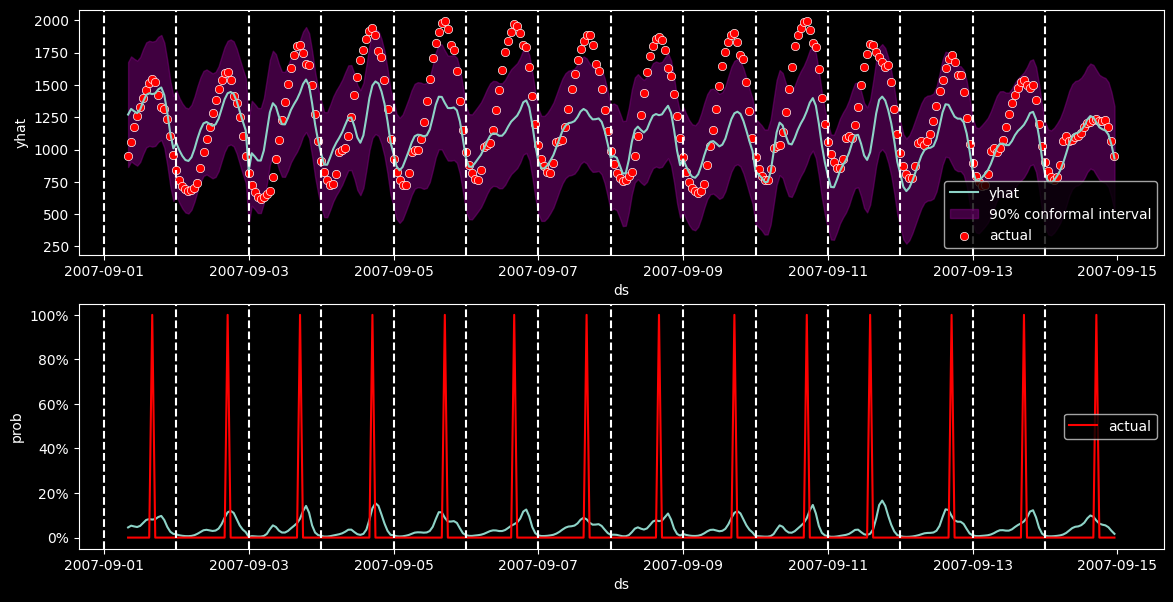

In [48]:
def forecast_and_prob_plot(pred_probs, method='conformal', start_time=None, end_time=None):
    if method == 'conformal':
        upper = 'yhat1 + qhat1'
        lower = 'yhat1 - qhat1'
        shade_color='purple'
    elif method == 'quantile':
        upper = 'yhat1 95.0%'
        lower = 'yhat1 5.0%'
        shade_color='green'
    else:
        raise(f'method {method} not implemented')


    if start_time is not None:
        pred_probs = pred_probs[pred_probs.ds >= start_time]
    if end_time is not None:
        pred_probs = pred_probs[pred_probs.ds <= end_time]

    fig, (ax1, ax2) = plt.subplots(2,1)
    sns.lineplot(data=pred_probs, x='ds', y='yhat1', ax=ax1, label='yhat')
    sns.lineplot(data=pred_probs, x='ds', y='prob', ax=ax2)
    ax1.fill_between(
        pred_probs.ds,
        pred_probs[lower],
        pred_probs[upper],
        alpha=0.5,
        color=shade_color,
        label=f"{confidence_lvl:.0%} {method} interval")

    ax1.set_ylabel('yhat')
    ax1.legend()
    sns.scatterplot(data=pred_probs, x='ds', y='y', color='red', label='actual', ax=ax1)
    sns.lineplot(data=pred_probs, x='ds', y='is_max', color='red', label='actual', ax=ax2, label='pred prob')
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    for ud in pred_probs.ds.dt.strftime("%Y-%m-%d").unique():
        ax1.axvline(pd.to_datetime(ud), linestyle='dashed')
        ax2.axvline(pd.to_datetime(ud), linestyle='dashed')

forecast_and_prob_plot(conformal_probs, method='conformal', start_time='2007-09-01 00:00:00', end_time='2007-09-14 23:00:00')
# quantile_probs[quantile_probs.ds.dt.strftime("%Y-%m-%d") == '2007-11-13']

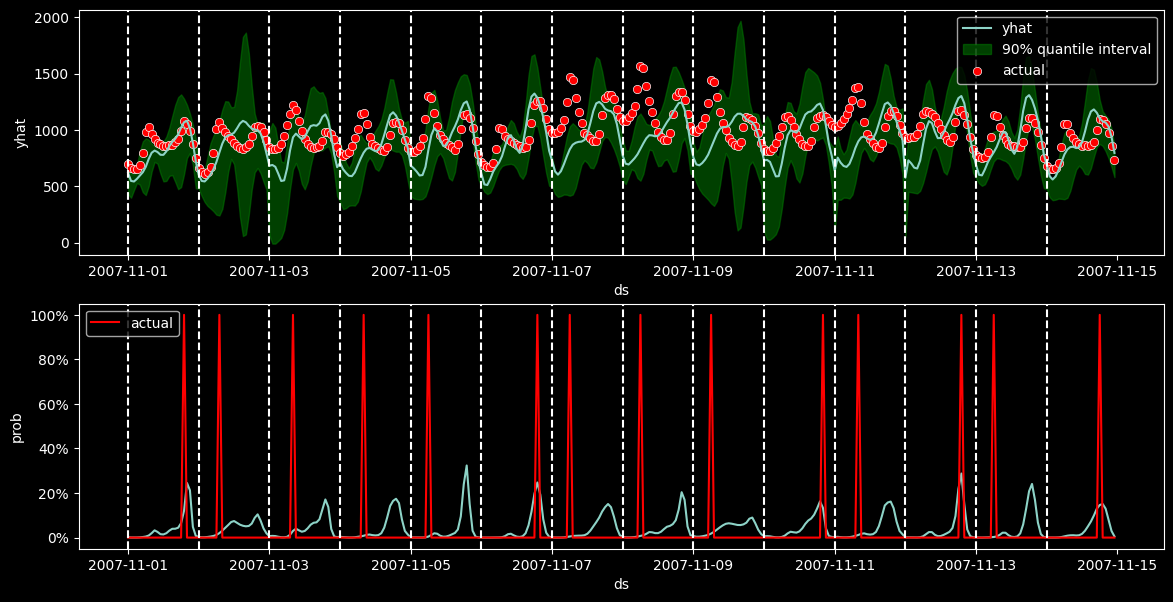

In [50]:
forecast_and_prob_plot(quantile_probs, method='quantile', start_time='2007-11-01 00:00:00', end_time='2007-11-14 23:00:00')

## Define Loss Function

Mean Squared Probability Loss:

$$ MSPL = \frac{1}{t} \sum_{1}^{t} (p_t - I\left(y_t =  max_{t* \in day} y_{t*}\right))^2 $$


Can use sklearn MSE function to calculate


In [51]:
conformal_probs['pt_est_max'] = (conformal_probs.groupby(conformal_probs.ds.dt.strftime("%Y-%m-%d"))['yhat1'].transform(max) == conformal_probs['yhat1']).astype(int)


In [52]:
from sklearn.metrics import mean_squared_error
loss_metrics = {
    'conformal': mean_squared_error(conformal_probs.is_max, conformal_probs.prob),
    'quantile': mean_squared_error(quantile_probs.is_max, quantile_probs.prob),
    'guess': mean_squared_error(quantile_probs.is_max, [1/24] * len(quantile_probs.is_max)),
    'pt_est': mean_squared_error(conformal_probs.is_max, conformal_probs.pt_est_max)
}
loss_metrics


{'conformal': 0.039670909712643275,
 'quantile': 0.03925226134757846,
 'guess': 0.04129090563165907,
 'pt_est': 0.07534246575342465}

In [ ]:
## Retrain on all data

m_deploy = NeuralProphet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    growth='off',
    # n_lags=1,
    # ar_reg=0.5,
    epochs=40,
    n_forecasts=1*366,
    quantiles=quantile_list
)
for i in range(7):
    m_deploy.add_seasonality(
        name=f"daily_dow{i}",
        period=1,
        fourier_order=4,
        condition_name=f"dow_{i}",
        # prior_scale=dow_prior,
    )
m_deploy.add_country_holidays(country_name="US")
m_deploy.add_future_regressor("mean_station_temp")

deploy_metrics = m_deploy.fit(
    df = mod_data,
    freq='H',
    progress=None,
    early_stopping=True,
)
deploy_metrics

In [ ]:
deploy_preds = m_deploy.predict(inference_data)
m_deploy.plot(deploy_preds)

In [ ]:
m_deploy.plot_components(deploy_preds, 'trend')

In [ ]:
norm.ppf(0.95)

In [ ]:
def forecast_to_probs(fcst):
    results = fcst[['ds', 'yhat1', 'yhat1 5.0%', 'yhat1 95.0%']].copy()
    results['sigma'] = (results['yhat1 95.0%'] - results['yhat1 5.0%']) / (2*norm.ppf(0.95))
    results['mu'] = results['yhat1']
    results['date'] = pd.to_datetime(results.ds.dt.strftime("%Y-%m-%d"))
    # results['hour'] = results.ds.dt.hour
    # Separate logic for daylight savings duplicates
    results['row_number'] = results.groupby('date').cumcount()+1

    results.drop(columns=['ds', 'yhat1', 'yhat1 5.0%', 'yhat1 95.0%'], inplace=True)

    res_list = []
    for date_stamp in list(results.date.unique()):
        single_day = results[results.date == date_stamp]
        single_day = single_day.merge(single_day, how='cross')
        single_day = single_day[single_day.row_number_x != single_day.row_number_y]
        single_day['mu'] = single_day['mu_x'] - single_day['mu_y']
        single_day['sigma'] = np.sqrt(single_day['sigma_x']**2 + single_day['sigma_y']**2)
        single_day['prob'] = single_day.apply(lambda row: 1 - norm.cdf(0, row['mu'], row['sigma']), axis=1)
        single_day = single_day.groupby(['date_x', 'row_number_x'])['prob'].prod().reset_index()
        res_list.append(single_day)

    return res_list
    
foo = forecast_to_probs(deploy_preds)

# results_preds = deploy_preds[['ds', 'yhat1', 'yhat1 5.0%', 'yhat1 95.0%']].copy()
# results_preds['sigma'] = (results_preds['yhat1 95.0%'] - results_preds['yhat1 5.0%']) / (2*norm.ppf(0.95))
# results_preds['mu'] = results_preds['yhat1']
# results_preds['date'] = pd.to_datetime(results_preds.ds.dt.strftime("%Y-%m-%d"))
# results_preds['hour'] = results_preds.ds.dt.hour
# # Separate logic for daylight savings duplicates
# results_preds['row_number'] = results_preds.groupby('date').cumcount()+1
# 
# results_preds.drop(columns=['ds', 'yhat1', 'yhat1 5.0%', 'yhat1 95.0%'], inplace=True)
# 
# from scipy.stats import norm
# 1-norm.cdf(1, loc=0, scale=1)

In [ ]:
foo

In [ ]:
test = results_preds[results_preds.date == '2008-01-01'].merge(
    results_preds[results_preds.date == '2008-01-01'],
    how='cross'
)
test = test[test.row_number_x != test.row_number_y]
test['mu'] = test['mu_x'] - test['mu_y']
test['sigma'] = np.sqrt(test['sigma_x']**2 + test['sigma_y']**2)
test['prob'] = test.apply(lambda row: 1 - norm.cdf(0, row['mu'], row['sigma']), axis=1)
display(test)
test.groupby('row_number_x')['prob'].prod() / test.groupby('row_number_x')['prob'].prod().sum()

In [ ]:
plot_data = conformal_preds[['ds', 'yhat1', 'yhat1 - qhat1', 'yhat1 + qhat1', 'yhat1 5.0%', 'yhat1 95.0%']].copy()

g=sns.lineplot(data=plot_data[plot_data.ds < '2008-01-02'], x='ds', y='yhat1')
ax =plt.gca()
ax.fill_between(
    plot_data.ds[plot_data.ds < '2008-01-02'],
    plot_data['yhat1 5.0%'][plot_data.ds < '2008-01-02'],
    plot_data['yhat1 95.0%'][plot_data.ds < '2008-01-02'],
    alpha=0.5,
    color='green',
    label=f"{confidence_lvl:.0%} quantile interval")
ax.legend()
g.set_title("Neural Prophet Forecast with Quantile Intervals")

In [ ]:
from scipy.stats import norm
1-norm.cdf(1, loc=0, scale=1)

In [ ]:
gug = pd.concat([foo_df, foo_df_inf])
gug = gug[gug.ds >= '2007-06-01']
foo_preds = m.predict(gug)
foo_preds

In [ ]:
m = NeuralProphet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_lags=1*24,
    ar_reg=0.5,
    epochs=20,
    n_forecasts = 2*24, # steps ahead to forecast
)
for i in range(7):
    m.add_seasonality(
        name=f"daily_dow{i}",
        period=1,
        fourier_order=4,
        condition_name=f"dow_{i}",
        # prior_scale=dow_prior,
    )
m.add_country_holidays(country_name="US")
m.add_future_regressor("max_station_temp")
m.add_future_regressor("min_station_temp")
m.add_future_regressor("mean_station_temp")
m.add_future_regressor("lag_24__min_station_temp")
m.add_future_regressor("lag_24__max_station_temp")
m.add_future_regressor("lag_24__mean_station_temp")

m.fit(
    df = train_data,
    freq='H',
    validation_df=tune_data
)

## Conformal Prediction

In [ ]:
confidence_lvl = 0.90
quantile_list = [round(((1 - confidence_lvl) / 2), 2), round((confidence_lvl + (1 - confidence_lvl) / 2), 2)]
method = 'naive'
alpha = 1 - confidence_lvl


m_cp = NeuralProphet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_lags=1*24,
    ar_reg=0.5,
    epochs=20,
    n_forecasts=2*24, # steps ahead to forecast
    quantiles=quantile_list
)
for i in range(7):
    m_cp.add_seasonality(
        name=f"daily_dow{i}",
        period=1,
        fourier_order=4,
        condition_name=f"dow_{i}",
    )
m_cp.add_country_holidays(country_name="US")
m_cp.add_future_regressor("max_station_temp")
m_cp.add_future_regressor("min_station_temp")
m_cp.add_future_regressor("mean_station_temp")
m_cp.add_future_regressor("lag_24__min_station_temp")
m_cp.add_future_regressor("lag_24__max_station_temp")
m_cp.add_future_regressor("lag_24__mean_station_temp")

train_metrics = m_cp.fit(
    df = train_data,
    freq='H',
)

In [ ]:
tune_fcst = m_cp.predict(tune_data)

In [ ]:
quantile_fcst = tune_fcst[['ds', 'y'] + [cn for cn in tune_fcst.columns if 'yhat48' in cn]].copy()
g=sns.lineplot(data=quantile_fcst, x='ds', y='yhat48', label='forecast')
sns.scatterplot(data=quantile_fcst, x='ds', y='y', color='red', label='actual')
ax = plt.gca()
ax.fill_between(
    quantile_fcst.ds,
    quantile_fcst['yhat48 5.0%'],
    quantile_fcst['yhat48 95.0%'],
    alpha=0.5,
    color='green',
    label=f"{confidence_lvl:.0%} quantile band")
ax.legend()
g.set_title("Neural Prophet Forecast with Quantile Intervals")

In [ ]:

naive_cp_forecast = m_cp.conformal_predict(
    pd.concat([train_data, tune_data]),
    calibration_df=test_data,
    alpha=alpha,
    method=method,
    plotting_backend="plotly-static",
    # show_all_PI=True,
)

In [ ]:

interval_fcst = naive_cp_forecast[['ds', 'y'] + [cn for cn in naive_cp_forecast.columns if 'yhat48' in cn]].copy()
g=sns.lineplot(data=interval_fcst, x='ds', y='yhat48', label='forecast')
sns.scatterplot(data=interval_fcst, x='ds', y='y', color='red', label='actual')
ax = plt.gca()
ax.fill_between(
    interval_fcst.ds,
    interval_fcst['yhat48 5.0%'],
    interval_fcst['yhat48 95.0%'],
    alpha=0.5,
    color='purple',
    label=f"{confidence_lvl:.0%} conformal interval")
ax.legend()
g.set_title("Neural Prophet Forecast with Conformal Prediction Intervals")

In [ ]:
uncertainty_res = uncertainty_evaluate(naive_cp_forecast)
uncertainty_res = uncertainty_res.T.reset_index()
uncertainty_res.columns = ['horizon', 'method', 'metric', 'value']
uncertainty_res['horizon_num'] = uncertainty_res['horizon'].str.slice(4,).astype(int)
sns.relplot(
    data=uncertainty_res[~uncertainty_res.metric.str.contains('qhat')],
    x="horizon_num", y="value",
    hue="method", col="metric",
    kind="line", facet_kws=dict(sharex=True, sharey=False),
)

## Retrain on all Data

In [ ]:
# Retrain with all data - use last 2 months as calibration data

deploy_mod = NeuralProphet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_lags=1*12,
    ar_reg=0.5,
    epochs=20,
    n_forecasts=7*24, # steps ahead to forecast
    quantiles=quantile_list
)
for i in range(7):
    deploy_mod.add_seasonality(
        name=f"daily_dow{i}",
        period=1,
        fourier_order=4,
        condition_name=f"dow_{i}",
    )
deploy_mod.add_country_holidays(country_name="US")
deploy_mod.add_future_regressor("max_station_temp")
deploy_mod.add_future_regressor("min_station_temp")
deploy_mod.add_future_regressor("mean_station_temp")
deploy_mod.add_future_regressor("lag_24__min_station_temp")
deploy_mod.add_future_regressor("lag_24__max_station_temp")
deploy_mod.add_future_regressor("lag_24__mean_station_temp")

deploy_metrics = deploy_mod.fit(
    df = mod_data,
    freq='H',
)
deploy_metrics

In [ ]:
inference_preds = deploy_mod.conformal_predict(
    pd.concat([mod_data, inference_data]),
    calibration_df=test_data,
    alpha=alpha,
    method='naive'
)

In [ ]:
for cn in inference_preds.columns:
    print(cn)

inference_preds[['ds', 'y'] + [f"qhat{i}" for i in range(1,49)]]

In [ ]:
deploy_cp_forecast = deploy_mod.conformal_predict(
    inference_data.drop(columns='y'),
    calibration_df=test_data,
    alpha=alpha,
    method=method,
    plotting_backend="plotly-static",
    # show_all_PI=True,
)

In [ ]:
deploy_cp_forecast.tail()

In [ ]:


naive_forecast1 = m_cp.conformal_predict(
    df=tune_data.drop(columns='school_break'),
    calibration_df=test_data.drop(columns='school_break'),
    alpha=alpha,
    method=method,
    plotting_backend='plotly_static'
)

In [ ]:
naive_forecast1.columns
naive_forecast1[['ds', 'y', 'yhat48', 'yhat48 - qhat48', 'yhat48 + qhat48']]

In [ ]:
forecast1 = m.predict(test_data.drop(columns='school_break'))[24:]

In [ ]:
foo = forecast1[forecast1.yhat24.notna()][['ds', 'y', 'yhat24']].copy()
foo['resid'] = foo['y'] - foo['yhat24']

sns.lineplot(data=foo, x='ds', y='resid')

In [ ]:
?NeuralProphet

In [ ]:
?m.plot_components

In [ ]:
?m.get_latest_forecast

In [ ]:
tune_fcst[['ds', 'y'] + [cn for cn in tune_fcst.columns if "yhat" in cn]]

In [ ]:
fcst = m.predict(
    mod_data[[
        'ds', 'y',
        'dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6',
        'max_station_temp', 'min_station_temp', 'mean_station_temp',
        'lag_24__min_station_temp', 'lag_24__max_station_temp', 'lag_24__mean_station_temp',
    ]]
)
fcst

# m.plot(fcst)

In [ ]:
fcst['resid24'] = fcst['y'] - fcst['yhat24']


In [ ]:
sns.lineplot(data=fcst, x='ds', y='resid24')

In [ ]:
m.get_latest_forecast(fcst)

In [ ]:
m.plot_components(fcst)

In [ ]:
fcst['residual'] = fcst['y'] - fcst['yhat1']

In [ ]:
util.slider_plot(data=fcst, x='ds', y='residual')

In [ ]:
!pip3 install statsmodels

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
plot_data = fcst[fcst.residual.notna()]
acf(plot_data['residual'])
plot_acf(plot_data['residual'])

In [ ]:
mod_data[:-3].apply(lambda x: x.isna().sum())

In [ ]:
forecast.head()

In [ ]:
m.plot(forecast)

In [ ]:
confidence_lvl = 0.90
quantile_list = [round(((1 - confidence_lvl) / 2), 2), round((confidence_lvl + (1 - confidence_lvl) / 2), 2)]
method = 'naive'
alpha = 1 - confidence_lvl

In [ ]:
inference_preds = pd.read_csv("../data/inference_preds_nforecasts336.csv")
# inference_preds.ds = pd.to_datetime(inference_preds)

In [ ]:
conformal_std = inference_preds[[cn for cn in inference_preds.columns if 'qhat' in cn and 'yhat' not in cn]].apply(max).reset_index()
conformal_std.columns = ['horizon', 'qhat']
conformal_std['horizon'] = conformal_std.horizon.str[4:].astype(np.float64) / 24
sns.lineplot(data=conformal_std, x='horizon', y='qhat')

In [ ]:
conformal_std

In [ ]:
inference_preds[inference_preds.ds >= '2008-01-01']